In [2]:
import os
import numpy as np
import pandas as pd
import umap
import time
import json
import requests
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

target_uniprots = ["P37840", "P04637", "P02686", "P07305", "O00488", "Q9NYB9", "P06401", "Q16186", "S6B291", "P23441"]


/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWa

In [3]:
### Load sequences and annotations for disprot

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

# Disprot
# embeddir="/data/franco/disorder_flavours/testset/" #"/data/franco/datasets/prot_embedding_weights/disprot/halft5/"
fasta_dir = "./disprot/fasta/" #"/data/franco/datasets/disprot/fasta/"
fasta_files = [f"{u}.fasta" for u in target_uniprots]
counter = 0

# find annotation for each sequence
annotfile = "./disprot/DisProt_release_2022_06_reformat_annot.fasta" #/data/franco/datasets/disprot/
annotdir  = None
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)
sequences = get_sequences(fastadir=fasta_dir, fastafile=None)

In [4]:
### Make sure seq and annotations length match, and embed test proteins
annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)
    
msequences  = list()
mannots     = list()
uniprots    = list()
counter = 0
for s in sequences:
    if "|" in s.name:
        uniprot_id = s.name.split("|")[1].strip()
    else:
        uniprot_id = s.name.split()[0].strip()
    if uniprot_id in target_uniprots:
        print(uniprot_id)
        aa_sequence = str(s.seq).upper()
        if len(aa_sequence) == len(annot_dict[uniprot_id]):
            uniprots.append(uniprot_id)
            msequences.append(aa_sequence)
            mannots.append(annot_dict[uniprot_id])
            counter += 1
        else:
            print("Seq length and annot do not match")
            print(len(annot_dict[uniprot_id]), uniprot_id, len(aa_sequence))
print(f"Loaded {counter} proteins")

S6B291
P04637
P23441
Q16186
P06401
O00488
P02686
P37840
Q9NYB9
P07305
Loaded 10 proteins


In [5]:
## Download AlphaFold2 models for target uniprots from disprot

if not os.path.exists("AF"):
    os.makedirs("AF")
    
for unip in target_uniprots:
    file = f"./AF/AF-{unip}-F1-model_v4.cif"
    if not os.path.exists(file):
        res = requests.get(f"https://alphafold.ebi.ac.uk/files/AF-{unip}-F1-model_v4.cif")
        if res.status_code == 200:
            print(unip)
            with open(file, 'w') as outfmt:
                outfmt.write(res.content.decode())
    else:
        print(f"File exists: {unip}")

File exists: P37840
File exists: P04637
File exists: P02686
File exists: P07305
File exists: O00488
File exists: Q9NYB9
File exists: P06401
File exists: Q16186
File exists: S6B291
File exists: P23441


In [6]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict

def parse_AF_CIF(file):
    # read in the CIF file.
    # file = "./AF/AF-P02686-F1-model_v4.cif"
    pdb_info = MMCIF2Dict(file)

    seq = pdb_info["_entity_poly.pdbx_seq_one_letter_code"][0].replace("\n", "")

    pLDDT_seq = pdb_info['_ma_qa_metric_local.label_seq_id']
    pLDDT = pdb_info['_ma_qa_metric_local.metric_value']

    dssp_type = pdb_info['_struct_conf.conf_type_id']
    dssp_beg  = pdb_info['_struct_conf.beg_label_seq_id']
    dssp_end  = pdb_info['_struct_conf.end_label_seq_id']
    
    seq_placeholder = ["-" for i in range(len(seq))]
    for i in range(len(dssp_type)):
        if dssp_type[i].startswith("HELX"):
            letter = "H"
            beg = int(dssp_beg[i])
            end = int(dssp_end[i])
            for j in range(beg-1, end):
                seq_placeholder[j] = letter
        if dssp_type[i].startswith("STRN"):
            letter = "B"
            beg = int(dssp_beg[i])
            end = int(dssp_end[i])
            for j in range(beg-1, end):
                seq_placeholder[j] = letter
    if len(seq) == len(pLDDT) and len(seq) == len(seq_placeholder):
        return seq, pLDDT, seq_placeholder
    else:
        raise

In [21]:
AF_dict = dict()

for i, unip in enumerate(target_uniprots):
    file = f"./AF/AF-{unip}-F1-model_v4.cif"
    seq, pLDDT, dssp = parse_AF_CIF(file)
    AF_dict[unip] = dict()
    AF_dict[unip]["seq"] = seq
    AF_dict[unip]["pLDDT"] = pLDDT
    AF_dict[unip]["disorder"] = mannots[uniprots.index(unip)]
    AF_dict[unip]["ss"] = dssp
    if AF_dict[unip]["seq"] == msequences[uniprots.index(unip)]:
        if len(AF_dict[unip]["disorder"]) == len(AF_dict[unip]['seq']):
            print("OK")

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [22]:
x = list()
cat = list()
for unip in AF_dict:
    x = x + AF_dict[unip]["pLDDT"]
    cat = cat + AF_dict[unip]["ss"]

In [23]:
x = np.array([float(i) for i in x])

In [24]:
ix_NA = [i for i in range(len(cat)) if cat[i] == "-"]
ix_H = [i for i in range(len(cat)) if cat[i] == "H"]
ix_B = [i for i in range(len(cat)) if cat[i] == "B"]

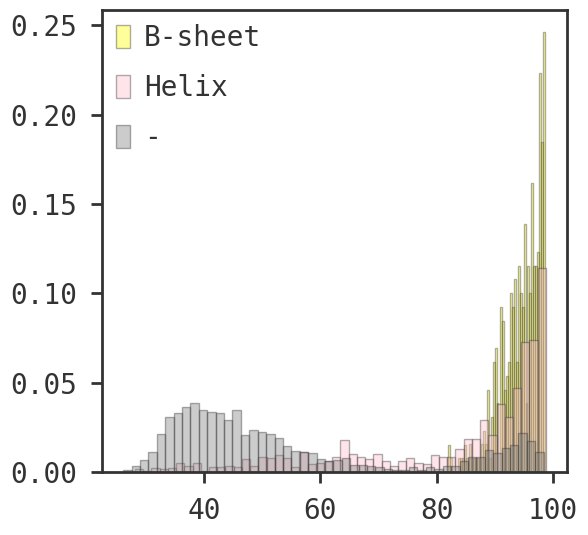

In [25]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(x[ix_B], bins=50, density=True, label="B-sheet", alpha=0.4, color='yellow')
ax.hist(x[ix_H], bins=50, density=True, label="Helix", alpha=0.4, color="pink")
ax.hist(x[ix_NA], bins=50, density=True, label="-", alpha=0.4, color='gray')
ax.legend()
plt.show()

In [26]:
with open("AF2_testset.json", 'w') as outfmt:
    json.dump(AF_dict, outfmt)
